# **Artificial Neural Networks and Deep Learning**

---

## ⚙️ **Libraries Import**

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import torch.nn.functional as F

logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import pickle

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.6.0+cu124
Device: cuda


## ⏳ **Data Loading**

In [3]:
DATASET_ROOT = Path("./dataset")

# --- 2️⃣ Kaggle ---
DATASET_ROOT = Path("/kaggle/input/pirate-pain")

# --- 3️⃣ Server o cluster privato (es. Westworld/Elysium) ---
# DATASET_ROOT = Path("/multiverse/datasets/private_dataset/pirate_pain")


In [4]:
import pandas as pd

# Caricamento dati
X_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train.csv")
X_TRAIN = pd.read_csv(DATASET_ROOT / "pirate_pain_train.csv")

y_train = pd.read_csv(DATASET_ROOT / "pirate_pain_train_labels.csv")
Y_TRAIN = pd.read_csv(DATASET_ROOT / "pirate_pain_train_labels.csv")

X_test  = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")

print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test:  {X_test.shape}")

  X_train: (105760, 40)
  y_train: (661, 2)
  X_test:  (211840, 40)


## 🔎 **Exploration and Data Analysis**

In [5]:
# MERGE BETWEEN TRAIN DATA AND LABELS
# the labels are in a separated file linked through 'sample_index
# here we merge X_train and y_train in a unique Dataframe to explore

train_merge = X_train.merge(y_train, on="sample_index", how="left")

# check whether all the labels have been associated or not
missing_labels = train_merge["label"].isna().sum()
if missing_labels > 0:
    print(f"{missing_labels} rows without a label")

# check
print(train_merge[["sample_index","time","label"]].head())
print("Class Distribution")
print(train_merge["label"].value_counts())

   sample_index  time    label
0             0     0  no_pain
1             0     1  no_pain
2             0     2  no_pain
3             0     3  no_pain
4             0     4  no_pain
Class Distribution
label
no_pain      81760
low_pain     15040
high_pain     8960
Name: count, dtype: int64


In [6]:
print(y_train["label"].value_counts())

label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64


## 🔄 **Data Preprocessing**

In [7]:
def dataset_conversion_type_embed_ready(df):
    """
    Minimal, embedding-friendly preprocessing:
    - joints: float32 (continuous features)
    - pain_survey_*: int64 indices (0..2) for embeddings
    - n_legs/hands/eyes: mapped to {0,1} as int64 for embeddings
    Returns: df, meta
    """
    df = df.copy()

    # 1) continuous features
    joint_cols = [c for c in df.columns if c.startswith("joint_")]
    df[joint_cols] = df[joint_cols].astype("float32")

    # 2) surveys as categorical indices (already 0/1/2)
    pain_survey_cols = [c for c in df.columns if c.startswith("pain_survey_")]
    df[pain_survey_cols] = df[pain_survey_cols].astype("int64")

    # 3) 2-way categoricals → indices
    legs_map  = {"two": 0, "one+peg_leg": 1}
    hands_map = {"two": 0, "one+hook_hand": 1}
    eyes_map  = {"two": 0, "one+eye_patch": 1}

    if "n_legs" in df.columns:
        df["n_legs"]  = df["n_legs"].map(legs_map).astype("int64")
    if "n_hands" in df.columns:
        df["n_hands"] = df["n_hands"].map(hands_map).astype("int64")
    if "n_eyes" in df.columns:
        df["n_eyes"]  = df["n_eyes"].map(eyes_map).astype("int64")

    # 4) define columns
    cat_two_cols = [c for c in ["n_legs","n_hands","n_eyes"] if c in df.columns]
    cat_cols = pain_survey_cols + cat_two_cols
    cont_cols = joint_cols  # keep only joints as continuous

    # 5) cardinals for embeddings (compute on TRAIN ONLY in CV, reuse for VAL/TEST)
    cardinals = {c: int(df[c].nunique()) for c in cat_cols}
    # suggested tiny dims: 1 for binaries, 2 for 3-class surveys
    emb_dims = {c: (1 if cardinals[c] == 2 else 2) for c in cat_cols}

    meta = {
        "cont_cols": cont_cols,
        "cat_cols":  cat_cols,
        "cardinals": cardinals,
        "emb_dims":  emb_dims,
        "maps": {"n_legs": legs_map, "n_hands": hands_map, "n_eyes": eyes_map},
    }
    return df, meta


In [8]:
def preprocess_joints(df, 
                      drop_redundant=False, 
                      drop_near_zero=False, 
                      drop_low_var=False,
                      verbose=True):
    """
    Simplify joint_* preprocessing based on EDA results.
    Removes constant, redundant, or near-zero-variance joints.

    Returns a (df_out, feature_cols) tuple.
    """
    joint_cols = sorted([c for c in df.columns if c.startswith("joint_")],
                        key=lambda x: int(x.split("_")[1]))
    drop = set()

    # 1 Drop constant joint_30
    if "joint_30" in joint_cols:
        drop.add("joint_30")

    #  Drop redundant joints (from correlation heatmap)
    if drop_redundant:
        for c in ["joint_01", "joint_02", "joint_05"]:
            if c in joint_cols:
                drop.add(c)

    # Drop near-zero variance joints (joint_13–25)
    if drop_near_zero:
        for i in range(13, 26):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # (Optional) Drop low-variance but not-zero joints (joint_26–29)
    if drop_low_var:
        for i in range(26, 30):
            c = f"joint_{i:02d}"
            if c in joint_cols:
                drop.add(c)

    # apply
    kept = [c for c in joint_cols if c not in drop]
    df_out = df.drop(columns=list(drop), errors="ignore")

    if verbose:
        print(f"[preprocess_joints] start={len(joint_cols)} | kept={len(kept)} | dropped={len(drop)}")
        if drop:
            print("  • dropped:", sorted(list(drop)))

    return df_out, kept


In [9]:
X_train, _ = preprocess_joints(X_train)
X_test, _ = preprocess_joints(X_test)

[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']
[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']


## 🔄 **Data Preprocessing**

In [10]:
# 1) Fit preprocessing on TRAIN ONLY
X_train, meta = dataset_conversion_type_embed_ready(X_train)
# BEFORE calling build_sequences, check your DataFrame
print("\n=== PREPROCESSING CHECK ===")
pain_cols = [c for c in X_train.columns if c.startswith('pain_survey_')]
print(f"Pain columns in X_train: {pain_cols}")
print(f"Pain column dtypes: {X_train[pain_cols].dtypes}")
print(f"Pain unique values:")
for col in pain_cols:
    print(f"  {col}: {X_train[col].unique()}")

static_cols = ['n_legs', 'n_hands', 'n_eyes']
print(f"\nStatic columns in X_train: {[c for c in static_cols if c in X_train.columns]}")
for col in static_cols:
    if col in X_train.columns:
        print(f"  {col} dtype: {X_train[col].dtype}")
        print(f"  {col} unique: {X_train[col].unique()}")
print("===========================\n")

# 2) Apply the SAME mappings/cardinals to TEST
#    (pain_survey_* are already 0/1/2; for n_legs/hands/eyes we reuse meta["maps"])
X_test = X_test.copy()
for c, m in meta["maps"].items():
    if c in X_test.columns:
        X_test[c] = X_test[c].map(m).astype("int64")

# Cast types consistently with train
X_test[meta["cont_cols"]] = X_test[meta["cont_cols"]].astype("float32")
for c in meta["cat_cols"]:
    X_test[c] = X_test[c].astype("int64")

# 3) Sanity checks
print("Train cont/cat:", len(meta["cont_cols"]), len(meta["cat_cols"]))
print("Train cont cols:", meta["cont_cols"][:5], "…")
print("Train cat  cols:", meta["cat_cols"])
print("Test has all cont cols?", set(meta["cont_cols"]).issubset(X_test.columns))
print("Test has all cat  cols?", set(meta["cat_cols"]).issubset(X_test.columns))

# Optional: verify cardinalities didn’t explode on test (should be ≤ train)
for c in meta["cat_cols"]:
    tr_card = meta["cardinals"][c]
    te_card = int(X_test[c].nunique())
    if te_card > tr_card:
        print(f"WARNING: column {c} has unseen categories in TEST (train={tr_card}, test={te_card})")



=== PREPROCESSING CHECK ===
Pain columns in X_train: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Pain column dtypes: pain_survey_1    int64
pain_survey_2    int64
pain_survey_3    int64
pain_survey_4    int64
dtype: object
Pain unique values:
  pain_survey_1: [2 0 1]
  pain_survey_2: [0 2 1]
  pain_survey_3: [2 0 1]
  pain_survey_4: [1 2 0]

Static columns in X_train: ['n_legs', 'n_hands', 'n_eyes']
  n_legs dtype: int64
  n_legs unique: [0 1]
  n_hands dtype: int64
  n_hands unique: [0 1]
  n_eyes dtype: int64
  n_eyes unique: [0 1]

Train cont/cat: 30 7
Train cont cols: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04'] …
Train cat  cols: ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes']
Test has all cont cols? True
Test has all cat  cols? True


In [11]:
# Step 1 — Copy merged train and raw test
train_dataset = X_train.copy()

In [12]:
# to reload quickly
X_train = train_dataset

In [13]:
print("Train columns:", X_train.columns.tolist())
print("Test columns:", X_test.columns.tolist())

train_only = [c for c in X_train.columns if c not in X_test.columns]
test_only  = [c for c in X_test.columns if c not in X_train.columns]

if train_only or test_only:
    print("Column mismatch detected!")
    if train_only:
        print("  Present only in TRAIN:", train_only)
    if test_only:
        print("  Present only in TEST:", test_only)
else:
    print("✅ Train and Test have identical columns.")

Train columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
Test columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
✅ T

In [14]:
# Step 1. temporary merge X_train + y_train to create splits ---
train_merged = X_train.merge(y_train, on="sample_index")
print(train_merged.shape)

# Step 2. retrieve unique indexes and labels to stratify ---
unique_samples = train_merged['sample_index'].unique()
y_seq = train_merged.groupby('sample_index')['label'].first().reindex(unique_samples).values

# Step 3. Divide in train e val (stratified) ---

train_idxs, val_idxs = train_test_split(unique_samples, test_size=0.20, random_state=SEED, stratify=y_seq)
print(f"Train Size: {len(train_idxs)}, Val Size: {len(val_idxs)}, total: {len(train_idxs)+len(val_idxs)}")


(105760, 40)
Train Size: 528, Val Size: 133, total: 661


In [15]:
# Step 4. Apply split on X e y (separately) ---
df_train = train_merged[train_merged['sample_index'].isin(train_idxs)]
df_val   = train_merged[train_merged['sample_index'].isin(val_idxs)]

In [16]:
# X: only features
X_train = df_train.drop(columns=['label'])
X_val   = df_val.drop(columns=['label'])

# y: one label for each sequence
y_train = df_train.groupby("sample_index")["label"].first().values
y_val   = df_val.groupby("sample_index")["label"].first().values

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train: {len(y_train)}, y_val: {len(y_val)}")

X_train shape: (84480, 39), X_val shape: (21280, 39)
y_train: 528, y_val: 133


In [17]:
# Define mapping once
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert y_train/y_val from string → int
y_train = np.array([label_mapping[l] for l in y_train])
y_val   = np.array([label_mapping[l] for l in y_val])

# Compute label distributions
train_counts = {inv_label_mapping[k]: np.sum(y_train == k) for k in np.unique(y_train)}
val_counts   = {inv_label_mapping[k]: np.sum(y_val == k) for k in np.unique(y_val)}

print("Training labels:", train_counts)
print("Validation labels:", val_counts)


Training labels: {'no_pain': 408, 'low_pain': 75, 'high_pain': 45}
Validation labels: {'no_pain': 103, 'low_pain': 19, 'high_pain': 11}


### Normalisation

In [18]:
scale_columns = [col for col in X_train.columns if col.startswith("joint_")]

# calculate the minimum and maximum values from the training data only
mins = X_train[scale_columns].min()
maxs = X_train[scale_columns].max()

# apply normalisation to the specified columns in all datasets (training and validation)
for column in scale_columns:

    # normalise the training set
    X_train[column] = (X_train[column] - mins[column]) / (maxs[column] - mins[column])

    # normalise the validation set
    X_val[column] = (X_val[column] - mins[column]) / (maxs[column] - mins[column])

    # normalise the test set
    X_test[column] = (X_test[column] - mins[column]) / (maxs[column] - mins[column])

In [19]:
print("Train:", X_train[scale_columns].min().min(), "→", X_train[scale_columns].max().max())
print("Val:  ", X_val[scale_columns].min().min(),   "→", X_val[scale_columns].max().max())
print("Test: ", X_test[scale_columns].min().min(),   "→", X_test[scale_columns].max().max())


Train: 0.0 → 1.0
Val:   -0.007747788447886705 → 7.217308044433594
Test:  -0.07219822704792023 → 4.829583644866943


In [20]:
# Display the first five rows of the training DataFrame
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

X_train, y_train

(84480, 39) (528,)
(21280, 39) (133,)


(        sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
 0                  0     0              2              0              2   
 1                  0     1              2              2              2   
 2                  0     2              2              0              2   
 3                  0     3              2              2              2   
 4                  0     4              2              2              2   
 ...              ...   ...            ...            ...            ...   
 105755           660   155              2              2              0   
 105756           660   156              2              2              0   
 105757           660   157              0              2              2   
 105758           660   158              2              2              2   
 105759           660   159              2              2              2   
 
         pain_survey_4  n_legs  n_hands  n_eyes  joint_00  ...  joint_20  \
 0        

In [21]:
def build_sequences(
    df: pd.DataFrame,
    y: pd.DataFrame | np.ndarray | None = None,
    window: int | None = None,
    stride: int | None = None,
    pad: bool = False,
    add_time_features: bool = True
):
    """ 
    Build sequences from the dataset, either:
      - full-length per sample_index (when window/stride are None), or
      - sliding windows with given window and stride.

    Data assumptions for THIS notebook:
      • df already normalized/mapped (categoricals numeric; e.g., n_legs/hands/eyes ∈ {0,1})
      • df has columns: ['sample_index','time', joint_*, pain_survey_*, n_legs, n_hands, n_eyes]
      • each sample_index has T=160 rows (fixed-length), but we still allow windowing/stride

    Returns:
        dataset: np.ndarray of shape (N,T,F) or (N,window,F)
        labels:  np.ndarray of shape (N,) if y is provided, else None
    """
    # ------------------------------------------------------------------
    # Feature groups (already numeric at this stage)
    joint_cols  = [c for c in df.columns if c.startswith('joint_')]
    pain_cols   = [c for c in df.columns if c.startswith('pain_survey_')]
    static_cols = [c for c in ['n_legs', 'n_hands', 'n_eyes'] if c in df.columns]

    # Keep only the necessary columns in a copy; preserve order
    cols_needed = ['sample_index', 'time'] + joint_cols + pain_cols + static_cols
    df = df[cols_needed].copy()

    # Sort to preserve chronological order within each sequence
    df = df.sort_values(["sample_index", "time"])

    # If labels are provided, build a lookup dictionary: sample_index → label
    label_dict = None
    if y is not None:
        if isinstance(y, np.ndarray):
            # Build mapping using the unique order of sample_index in df
            unique_ids = df["sample_index"].unique()
            label_dict = {sid: int(lbl) for sid, lbl in zip(unique_ids, y)}
        elif isinstance(y, pd.DataFrame):
            # Expect columns ['sample_index','label'] with already-int-mapped labels
            label_dict = dict(zip(y["sample_index"], y["label"]))

    # Prepare outputs
    dataset = []
    labels  = []

    # If no window/stride provided → fall back to full-length per sequence
    full_length_mode = (window is None or stride is None)

    # Iterate over each sequence
    for sid, group in df.groupby("sample_index", sort=False):
        # --- Extract groups (preserve types for embeddings) ---
        X_joints = group[joint_cols].to_numpy(dtype=np.float32)        # (T, J) - continuous features

        # IMPORTANT: Pain survey features are categorical indices {0,1,2}
        # Keep as int64 first, then convert to float32 to preserve exact integer values
        X_pain = group[pain_cols].to_numpy(dtype=np.int64)             # (T, 4) - categorical indices
        X_pain = X_pain.astype(np.float32)                              # Convert to float32 but keep 0.0, 1.0, 2.0

        # IMPORTANT: Static features are categorical indices {0,1}
        # Keep as int64 first, then convert to float32 to preserve exact integer values
        if static_cols:
            X_static = group[static_cols].to_numpy(dtype=np.int64)     # (T, 3) - categorical indices
            X_static = X_static.astype(np.float32)                      # Convert to float32 but keep 0.0, 1.0
        else:
            X_static = None

        
        # Time features: extract normalized time + sinusoidal encoding
        if add_time_features:
            time_values = group['time'].to_numpy(dtype=np.float32)
            max_time = time_values.max()
            normalized_time = time_values / max_time if max_time > 0 else time_values
            time_sin = np.sin(2 * np.pi * normalized_time)
            time_cos = np.cos(2 * np.pi * normalized_time)
            X_time = np.stack([normalized_time, time_sin, time_cos], axis=1)  # (T, 3)
        else:
            X_time = None

        # Concatenate all feature groups along last dimension
        if X_static is not None:
            X_full = np.concatenate([X_joints, X_pain, X_static], axis=1)  # (T, F_total)
        else:
            X_full = np.concatenate([X_joints, X_pain], axis=1)            # (T, F_total)
        
        # Add time features if enabled
        if X_time is not None:
            X_full = np.concatenate([X_full, X_time], axis=1)              # (T, F_total + 3)

        T = X_full.shape[0]

        if full_length_mode:
            # ----- FULL-LENGTH MODE -----
            dataset.append(X_full)
            if label_dict is not None and sid in label_dict:
                labels.append(int(label_dict[sid]))
        else:
            # ----- WINDOWED MODE (window, stride) -----
            W = int(window)
            S = int(stride)
            assert W > 0 and S > 0, "window and stride must be positive integers"

            if pad and T % W != 0:
                # pad at the end with zeros to allow the last partial window
                pad_len = (W - (T % W)) % W
                if pad_len > 0:
                    X_pad = np.zeros((pad_len, X_full.shape[1]), dtype=np.float32)
                    X_seq = np.concatenate([X_full, X_pad], axis=0)
                else:
                    X_seq = X_full
                Tmax = X_seq.shape[0]
                idx = 0
                while idx + W <= Tmax:
                    dataset.append(X_seq[idx:idx+W])
                    if label_dict is not None and sid in label_dict:
                        labels.append(int(label_dict[sid]))
                    idx += S
            else:
                # no padding → only windows fully inside the sequence
                idx = 0
                while idx + W <= T:
                    dataset.append(X_full[idx:idx+W])
                    if label_dict is not None and sid in label_dict:
                        labels.append(int(label_dict[sid]))
                    idx += S

    # Convert to numpy arrays
    dataset = np.asarray(dataset, dtype=np.float32) if len(dataset) > 0 else np.empty((0, 0, 0), dtype=np.float32)
    labels  = np.asarray(labels,  dtype=np.int64)   if len(labels)  > 0 else None

    if dataset.size > 0:
        print(f"Built {len(dataset)} sequence{'s' if len(dataset)!=1 else ''}; each shape = {dataset[0].shape}")
    else:
        print("Built 0 sequences (check window/stride vs sequence length).")

    return dataset, labels


In [22]:
# --- ACF-DRIVEN WINDOWING (drop-in) ---------------------------------
# Goal:
#   Use autocorrelation (ACF) to pick a WINDOW_SIZE (W) and STRIDE (S)
#   that reflect how far the signal “remembers” its past.
#
# Design choices:
#   • We use ONLY joint_* signals (continuous), excluding pain_survey_* and
#     static cats (n_legs/hands/eyes), because ACF is meaningful for
#     continuous, time-varying signals. Surveys/cats would distort it.
#   • We compute ACF per joint, per sequence, then average to get a robust
#     "mean ACF" over the dataset (train only → no leakage).
#   • From the mean ACF curve we pick W via a simple heuristic:
#       1) first local peak (a natural cycle length)
#       2) else, first lag where ACF falls below a cutoff (memory fades)
#     then clamp to a safe lower bound (min_window) and snap to multiple of 4.
#
# How to read the outputs:
#   • W_SUGG = suggested window (steps of lookback the model should "see")
#   • S_SUGG = suggested stride (step between window starts; default W//4)
#   • n_windows = number of windows per sequence with length T=160
#   • covered_steps = n_windows * W  (overlaps → can exceed T)
#
# Keep in mind:
#   • This is NOT a replacement for cross-validation. Use CV to compare
#     W in a small neighborhood (e.g., W, W±4 or W±8) and keep what wins.
# ---------------------------------------------------------------------

def _acf_1d(x: np.ndarray, max_lag: int) -> np.ndarray:
    """
    Compute the autocorrelation function (ACF) for a 1D vector up to `max_lag`.

    Steps:
      1) Normalize x to zero-mean and unit-variance so the ACF is scale-free.
      2) Use np.correlate in 'full' mode to get correlation at all lags.
      3) Slice the non-negative lags [0..max_lag].
      4) Normalize by acf[0] (the variance) so ACF[0] == 1 and 0<=ACF<=1 (approx).

    Args:
      x (np.ndarray): 1D time series (length T)
      max_lag (int): maximum lag we want to evaluate (<= T-1)

    Returns:
      acf (np.ndarray): shape (max_lag+1,), acf[0]=1, acf[k]=similarity at lag k
    """
    x = x.astype(np.float64)
    x = (x - x.mean()) / (x.std() + 1e-8)      # protect from near-constant series
    acf_full = np.correlate(x, x, mode='full') # length 2T-1
    # Keep the right half: lags 0..max_lag (index starts at the center)
    acf = acf_full[len(x)-1 : len(x)-1 + max_lag + 1]
    # Normalize so that ACF[0] == 1 (divide by variance term)
    return acf / (acf[0] + 1e-8)

def mean_acf_over_joints(df, max_lag=80, sample_cap=256):
    """
    Compute the MEAN ACF across joints and (optionally) across a subset
    of sequences for speed. This gives a single, smooth ACF curve.

    Expected df columns:
      • 'sample_index', 'time', and many 'joint_*' columns

    Process:
      For each sequence (sample_index):
        - sort by time
        - build a (T, J) matrix of joint features
        - for each joint j, compute ACF_j[0..L] where L = min(max_lag, T-1)
        - average ACF over joints → one curve per sequence
      Average all sequence curves → mean ACF

    Why average?
      Reduces noise and avoids picking a window based on a single joint
      or a single quirky sequence.

    Args:
      df (DataFrame): TRAIN subset only (to avoid leakage)
      max_lag (int): maximum lag we consider (e.g., 80)
      sample_cap (int): if many sequences, randomly subsample this many
                        to keep runtime small

    Returns:
      lags (np.ndarray): [0, 1, ..., L]
      mean_acf (np.ndarray): averaged ACF curve, length L+1
    """
    joint_cols = [c for c in df.columns if c.startswith("joint_")]
    assert len(joint_cols) > 0, "No joint_* columns found."

    # Subsample sequences if needed (for speed on large datasets)
    sids = df["sample_index"].unique()
    if len(sids) > sample_cap:
        rng = np.random.default_rng(42)
        sids = rng.choice(sids, size=sample_cap, replace=False)

    acfs = []
    for sid in sids:
        # (T, J) matrix for this sequence
        seq = (df.loc[df["sample_index"] == sid]
                 .sort_values("time")[joint_cols].to_numpy(dtype=np.float32))
        T, J = seq.shape
        L = min(max_lag, T - 1)  # ACF defined up to T-1
        # ACF for each joint, then average across joints → one curve per sequence
        per_joint = []
        for j in range(J):
            per_joint.append(_acf_1d(seq[:, j], L))  # shape (L+1,)
        acfs.append(np.mean(np.stack(per_joint, axis=0), axis=0))  # (L+1,)

    # Average across sequences → single smooth ACF curve
    mean_acf = np.mean(np.stack(acfs, axis=0), axis=0)  # (L+1,)
    lags = np.arange(len(mean_acf))
    return lags, mean_acf

def suggest_window_from_acf(mean_acf: np.ndarray, min_window=12, cutoff=0.10):
    """
    Heuristic to convert the mean ACF curve into a WINDOW_SIZE (W).

    Intuition:
      • If there's a visible "cycle", the ACF will have a local peak at its period.
        → pick the first local maximum after lag=1 (we ignore lag=0..1).
      • If no clear peak, use the lag where correlation "dies out" (drops < cutoff).
        → pick first lag where ACF < cutoff (e.g., 0.10).
      • Clamp to a minimum window (min_window) so we don't get too tiny a W.
      • Snap to a multiple of 4 to make stride W//4 an integer (nice, common choice).

    Args:
      mean_acf (np.ndarray): curve from mean_acf_over_joints
      min_window (int): lower bound to keep W usable for training (default 12)
      cutoff (float): ACF threshold for "memory fades" (default 0.10)

    Returns:
      W (int): suggested window size
    """
    # 1) Look for the first local MAX after lag=1 (i.e., k >= 2)
    peak_lag = None
    for k in range(2, len(mean_acf) - 1):
        # local max if it is >= next and > previous
        if mean_acf[k] > mean_acf[k - 1] and mean_acf[k] >= mean_acf[k + 1]:
            peak_lag = k
            break

    # 2) First lag where ACF falls below cutoff (correlation has faded)
    below = np.where(mean_acf < cutoff)[0]
    drop_lag = int(below[0]) if len(below) else None

    # Combine signals (prefer a peak if present, else use drop)
    if peak_lag is not None and drop_lag is not None:
        # keep it within [min_window, drop_lag]
        W = min(max(peak_lag, min_window), drop_lag)
    elif peak_lag is not None:
        W = max(peak_lag, min_window)
    elif drop_lag is not None:
        W = max(drop_lag, min_window)
    else:
        # No clear info → conservative fallback
        W = max(24, min_window)

    # Safety clamp within [min_window, 160] (your T=160)
    W = int(np.clip(W, min_window, 160))

    # Snap to multiple of 4 so stride = W//4 is an integer
    if W % 4 != 0:
        W += (4 - (W % 4))
    return W

def suggest_stride(window: int) -> int:
    """
    Default stride choice: quarter window.
    Why? Good balance between:
      - enough overlap to preserve information
      - not exploding the number of windows too much
    """
    return max(1, window // 4)

# ---- RUN IT ON YOUR TRAIN DF (after normalization/mapping) ----------
# NOTE: Use df_train (TRAIN SPLIT ONLY) to avoid leaking validation info.
lags, mean_acf = mean_acf_over_joints(df_train, max_lag=80, sample_cap=256)

# Heuristic suggestions from ACF
W_SUGG = suggest_window_from_acf(mean_acf, min_window=12, cutoff=0.10)
S_SUGG = suggest_stride(W_SUGG)
print(f"[ACF] Suggested WINDOW_SIZE={W_SUGG}, STRIDE={S_SUGG}")

# Optional: coverage diagnostic for your fixed T=160
T = 160
n_windows = (T - W_SUGG) // S_SUGG + 1 if T >= W_SUGG else 0
covered = n_windows * W_SUGG  # can exceed T because windows overlap
print(f"[ACF] With T={T}: n_windows={n_windows}, covered_steps={covered}/{T}")
# --------------------------------------------------------------------

[ACF] Suggested WINDOW_SIZE=12, STRIDE=3
[ACF] With T=160: n_windows=50, covered_steps=600/160


In [23]:
# y_train_df must contain sample_index + label columns
y_train_df = pd.DataFrame({
    "sample_index": X_train["sample_index"].unique(),
    "label": y_train
})

X_train_seq_complete_window, y_train_seq_complete_window = build_sequences(X_train, y_train_df, window=160)

Built 528 sequences; each shape = (160, 40)


In [24]:
y_val_df = pd.DataFrame({
    "sample_index": X_val["sample_index"].unique(),
    "label": y_val
})

X_val_seq_complete_window, y_val_seq_complete_window = build_sequences(X_val, y_val_df, 160)

Built 133 sequences; each shape = (160, 40)


In [25]:
X_test_seq_complete_window, _ = build_sequences(X_test, window=160)  # no labels → returns (dataset, None)


Built 1324 sequences; each shape = (160, 40)


In [26]:
X_tr_win, y_tr_win = build_sequences(X_train, y_train, window=W_SUGG, stride=S_SUGG, pad=False)
X_va_win, y_va_win = build_sequences(X_val,y_val, window=W_SUGG, stride=S_SUGG, pad=False)
X_te_win, _        = build_sequences(X_test,None, window=W_SUGG, stride=S_SUGG, pad=False)


Built 26400 sequences; each shape = (12, 40)
Built 6650 sequences; each shape = (12, 40)
Built 66200 sequences; each shape = (12, 40)


In [27]:
from torch.utils.data import WeightedRandomSampler


labels_np = y_tr_win  # numpy array of shape (N_train_windows,)

# Count windows per class
class_sample_counts = np.bincount(labels_np, minlength=3)
# e.g. array([N_no, N_low, N_high])

# Inverse frequency weights: rarer class ⇒ larger weight
class_weights_for_sampling = 1.0 / (class_sample_counts + 1e-8)

# Per-sample weights: pick the weight of its class
sample_weights = class_weights_for_sampling[labels_np]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


In [28]:
input_shape = X_tr_win.shape[1:] # extract the shape of a single sequence
num_classes = len(np.unique(y_tr_win)) # how many unique pain level exists
input_shape, num_classes

((12, 40), 3)

In [29]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
# each dataset now pairs each (T,F) TENSOR WITH ITS LABEL
train_ds = TensorDataset(torch.from_numpy(X_tr_win), torch.from_numpy(y_tr_win))
val_ds   = TensorDataset(torch.from_numpy(X_va_win), torch.from_numpy(y_va_win))


In [30]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256

In [31]:

def make_loader(ds, batch_size, shuffle, drop_last, sampler=None):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    final_shuffle = shuffle
    if sampler is not None:
        final_shuffle = False

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=final_shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        sampler=sampler,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches aheads
    )

In [32]:
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, sampler=sampler, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [33]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    labels = yb.cpu().numpy()  # assuming (X, y) batch
    print('Batch class counts:', np.unique(labels, return_counts=True))
    break

Features batch shape: torch.Size([256, 12, 40])
Labels batch shape: torch.Size([256])
Batch class counts: (array([0, 1, 2]), array([92, 73, 91]))


## 🛠️ **Model Building**

In [34]:
class WeightLabelLoss(nn.Module):
    """
    Combines:
    - Advice 08/11: Class weights for imbalance
    - Advice 09/11: Label smoothing for generalization (per-class)
    """
    def __init__(self, num_classes=3, class_weights=None, smoothing_per_class=None):
        super().__init__()
        self.num_classes = num_classes
        
        # Per-class label smoothing
        if smoothing_per_class is None:
            # Default: more smoothing for majority, less for minority
            smoothing_per_class = [0.10, 0.05, 0.01]
        
        if isinstance(smoothing_per_class, (list, tuple)):
            # Convert list to tensor
            self.smoothing_per_class = torch.tensor(smoothing_per_class, dtype=torch.float32)
        else:
            # Single value: use for all classes
            self.smoothing_per_class = torch.tensor([smoothing_per_class] * num_classes, dtype=torch.float32)
        
        # Register as buffer (moves with model to GPU)
        self.register_buffer('smoothing', self.smoothing_per_class)
        
        # Class weights
        if class_weights is not None:
            self.register_buffer('class_weights', class_weights)
        else:
            self.register_buffer('class_weights', torch.ones(num_classes))
    
    def forward(self, pred, target):
        # Apply label smoothing
        log_probs = F.log_softmax(pred, dim=-1)
        batch_size = target.size(0)
        
        # Create smoothed targets with PER-CLASS smoothing
        smooth_targets = torch.zeros_like(pred)
        
        for i in range(batch_size):
            true_class = target[i].item()
            smoothing = self.smoothing[true_class].item()  # Get smoothing for this class
            confidence = 1.0 - smoothing
            
            # Distribute smoothing uniformly across other classes
            smooth_targets[i].fill_(smoothing / (self.num_classes - 1))
            smooth_targets[i, true_class] = confidence
        
        # Compute loss with class weights
        loss_per_sample = -(smooth_targets * log_probs).sum(dim=-1)
        
        # Apply class weights based on true label
        weights = self.class_weights[target]
        weighted_loss = (loss_per_sample * weights).mean()
        
        return weighted_loss


In [35]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [36]:
# CRITICAL: Count your features BEFORE creating model
joint_cols = [c for c in X_train.columns if c.startswith('joint_')]
pain_cols = [c for c in X_train.columns if c.startswith('pain_survey_')]
static_cols = ['n_legs', 'n_hands', 'n_eyes']

NUM_JOINT_FEATURES = len(joint_cols) 
NUM_PAIN_FEATURES = len(pain_cols) 
NUM_STATIC_FEATURES = len([c for c in static_cols if c in X_train.columns])  # 
NUM_TIME_FEATURES = 3

print(f"Feature counts:")
print(f"  Joint: {NUM_JOINT_FEATURES}")
print(f"  Pain: {NUM_PAIN_FEATURES}")
print(f"  Static: {NUM_STATIC_FEATURES}")
print(f"  Time: {NUM_TIME_FEATURES}")
print(f"  Total: {NUM_JOINT_FEATURES + NUM_PAIN_FEATURES + NUM_STATIC_FEATURES + NUM_TIME_FEATURES}")


Feature counts:
  Joint: 30
  Pain: 4
  Static: 3
  Time: 3
  Total: 40


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RecurrentClassifier(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            rec_dropout_rate=None,
            cnn_channels=None,
            cnn_kernel_size=3,
            cnn_dropout=None,
            use_pain_embeddings=True,
            pain_embedding_dim=4,
            num_joint_features=30,
            num_pain_features=4,
            num_static_features=3,
            num_time_features=3,
            use_attention=True
            ):
        super().__init__()
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.uses_cnn = cnn_channels is not None
        self.use_pain_embeddings = use_pain_embeddings
        self.use_attention = use_attention   
        # ---------------------------------------------
        # Store feature split indices (same as before)
        self.num_joint_features = num_joint_features
        self.num_pain_features = num_pain_features
        self.num_static_features = num_static_features
        self.num_time_features = num_time_features
        self.joint_end = num_joint_features
        self.pain_end = self.joint_end + num_pain_features
        self.static_end = self.pain_end + num_static_features
        # ---------------------------------------------
        # Check input size
        expected_input = num_joint_features + num_pain_features + num_static_features + num_time_features
        if input_size != expected_input:
            print(f"WARNING: input_size={input_size} but expected {expected_input}")
        # ---------------------------------------------
        # Embeddings (if enabled)
        if self.use_pain_embeddings:
            self.pain_embeddings = nn.ModuleList([
                nn.Embedding(num_embeddings=3, embedding_dim=pain_embedding_dim)
                for _ in range(num_pain_features)
            ])
            effective_input_size = (num_joint_features + num_pain_features * pain_embedding_dim + num_static_features + num_time_features)
        else:
            effective_input_size = input_size
        # ---------------------------------------------
        # Optionally CNN block
        if self.uses_cnn:
            self.cnn1 = nn.Conv1d(in_channels=effective_input_size,
                                  out_channels=cnn_channels,
                                  kernel_size=cnn_kernel_size,
                                  padding=cnn_kernel_size // 2)
            self.cnn_bn = nn.BatchNorm1d(cnn_channels)
            self.cnn_act = nn.ReLU()
            self.cnn_dropout = nn.Dropout(cnn_dropout if cnn_dropout is not None else dropout_rate)
            rnn_input_size = cnn_channels
        else:
            rnn_input_size = effective_input_size
        # ---------------------------------------------
        # RNN
        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        # ---------------------------------------------
        # Classifier layer (after attention output)
        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        self.classifier = nn.Linear(rnn_output_size, num_classes)
        self.rec_dropout = nn.Dropout(rec_dropout_rate) if rec_dropout_rate is not None else None
    
    def scaled_dot_product_attention(self, query, key, value):
        """
        Args:
            query: (batch, 1, d)
            key, value: (batch, seq_len, d)
        Computes attention weights and context.
        """
        # Compute dot products
        scores = torch.matmul(query, key.transpose(1,2))  # (batch, 1, seq_len)
        scores = scores / torch.sqrt(torch.tensor(query.size(-1), dtype=torch.float32, device=query.device))
        attn_weights = F.softmax(scores, dim=-1)          # (batch, 1, seq_len)
        context = torch.matmul(attn_weights, value)        # (batch, 1, d)
        context = context.squeeze(1)                      # (batch, d)
        return context, attn_weights.squeeze(1)

    def forward(self, x):
        # --- Embedding and feature split ---
        if self.use_pain_embeddings:
            X_joints = x[:, :, :self.joint_end]
            X_pain = x[:, :, self.joint_end:self.pain_end]
            X_static = x[:, :, self.pain_end:self.static_end]
            X_time = x[:, :, self.static_end:]
            pain_embedded_list = [self.pain_embeddings[i](X_pain[:,:,i].long()) for i in range(self.num_pain_features)]
            X_pain_embedded = torch.cat(pain_embedded_list, dim=-1)
            x = torch.cat([X_joints, X_pain_embedded, X_static, X_time], dim=-1)
        # --- Optionally CNN preprocessing ---
        if self.uses_cnn:
            x = x.transpose(1, 2)
            x = self.cnn1(x)
            x = self.cnn_bn(x)
            x = self.cnn_act(x)
            x = self.cnn_dropout(x)
            x = x.transpose(1, 2)
        # --- RNN ---
        rnn_out, hidden = self.rnn(x)  # rnn_out: (batch, seq_len, hidden_size * directions)

        # Use last hidden state as query for attention
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            final_hidden = torch.cat([hidden[-1,0,:,:], hidden[-1,1,:,:]], dim=1)  # (batch, rnn_output_size)
        else:
            final_hidden = hidden[-1]  # (batch, rnn_output_size)
        # --- Attention: query=final_hidden, key/value=all rnn_out ---
        if self.use_attention:
            query = final_hidden.unsqueeze(1)  # (batch, 1, rnn_output_size)
            context, attn_weights = self.scaled_dot_product_attention(query, rnn_out, rnn_out)
        else:
            context = final_hidden

        # --- Dropout and classification ---
        if self.rec_dropout is not None:
            context = self.rec_dropout(context)
        logits = self.classifier(context)  # (batch, num_classes)
        return logits  # Optionally also return attn_weights if you want visualization


## 🧠 **Model Training**

In [38]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [39]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, 
                    device, l1_lambda=0, l2_lambda=0,max_grad_norm=1.0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        if scaler is not None and device.type == 'cuda':
            scaler.scale(loss).backward()            # grads are scaled
            scaler.unscale_(optimizer)               # unscale to true grad values
            torch.nn.utils.clip_grad_norm_(          # CLIP true gradients (magnitude cap)
                model.parameters(), max_norm=max_grad_norm
            )
            scaler.step(optimizer)                   # safe optimizer.step() (skips on inf/NaN)
            scaler.update()                          # update scaling factor
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_f1

In [40]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_accuracy

In [41]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [42]:
def fit(model, train_loader, val_loader, epochs, train_criterion, val_criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, scheduler=None, # Added scheduler parameter
        evaluation_metric="val_f1", mode='max', 
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, train_criterion, optimizer, scaler, device
        )

        # Evaluate model on validation data without updating weights
        if val_loader is not None:
            val_loss, val_f1 = validate_one_epoch(model, val_loader, val_criterion, device)
        else:
            val_loss, val_f1 = None, None


        # Step the scheduler if provided (typically after validation)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) or isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                scheduler.step(val_f1)
            else:
                scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                if val_loss is not None:
                    print(f"Epoch {epoch:3d}/{epochs} | "
                          f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                          f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")
                else:
                    print(f"Epoch {epoch:3d}/{epochs} | "
                          f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f}")


        # Early stopping logic: monitor metric and save best model
        if patience > 0 and val_loader is not None:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break


    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
        
    if patience > 0:
        training_history['best_epoch'] = best_epoch
        training_history['best_metric'] = best_metric
        
    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## 🧮 **Network and Training Hyperparameters**

In [43]:
y_train_np = np.array(y_train)
num_classes = np.max(y_train_np) + 1
class_counts = np.bincount(y_train_np, minlength=num_classes)
total = len(y_train_np)

print("Training class distribution:")
for i, name in enumerate(['no_pain', 'low_pain', 'high_pain']):
    print(f"  {name} ({i}): {class_counts[i]} ({class_counts[i]/total*100:.1f}%)")

# SQRT dampening
max_count = class_counts.max()
class_weights_raw = max_count / class_counts
class_weights_dampened = np.sqrt(class_weights_raw)

# Convert to tensor (CRITICAL!)
class_weights = torch.tensor(class_weights_dampened, dtype=torch.float32)

print(f"\nClass weights (sqrt dampened): {class_weights}")
print(f"Type: {type(class_weights)}")

Training class distribution:
  no_pain (0): 408 (77.3%)
  low_pain (1): 75 (14.2%)
  high_pain (2): 45 (8.5%)

Class weights (sqrt dampened): tensor([1.0000, 2.3324, 3.0111])
Type: <class 'torch.Tensor'>


In [44]:
# ===== TRAINING CONFIGURATION =====
LEARNING_RATE = 3e-4
EPOCHS = 150
PATIENCE = 15

# ===== ARCHITECTURE =====
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 192

# ===== REGULARIZATION =====
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.2
L2_LAMBDA = 3e-5
L1_LAMBDA = 0

# ===== CNN CONFIGURATION =====
CNN_CHANNELS    = 48
CNN_KERNEL_SIZE = 3
CNN_DROPOUT     = 0.35



# Set up loss function and optimizer

# Loss function with FocalLabelSmoothing
train_criterion = WeightLabelLoss(
    num_classes=3,
).to(device)

val_criterion = nn.CrossEntropyLoss().to(device)

# model
MODEL='GRU'
RNN_TYPE=MODEL
BIDIRECTIONAL=True

In [45]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    rec_dropout_rate = RECURRENT_DROPOUT,
    bidirectional=BIDIRECTIONAL,
    cnn_channels=CNN_CHANNELS,                  # enables CNN1D preprocessing
    cnn_kernel_size=CNN_KERNEL_SIZE,                # usually 3, 5, or 7 works well
    cnn_dropout=CNN_DROPOUT,                  # (optional; default uses RNN dropout)
    rnn_type=MODEL
    ).to(device)
# recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
prefix = "bi_" if BIDIRECTIONAL else ""
experiment_name = prefix + MODEL.lower()
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
# x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer, 
#     T_0=15,        # Restart every 15 epochs
#     T_mult=2,      # Double restart period each time
#     eta_min=1e-6   # Minimum LR
# )

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',           # Maximize F1
    factor=0.5,           # Reduce LR by 50% when plateau
    patience=10,          # Wait 10 epochs before reducing
    verbose=True,
    min_lr=1e-6
)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [46]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    train_criterion=train_criterion,
    val_criterion=val_criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=MODEL.lower(),
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

best_epoch_number = training_history['best_epoch']
print(f"Best epoch was: {best_epoch_number}")

Training 150 epochs...
Epoch   1/150 | Train: Loss=0.9353, F1 Score=0.5339 | Val: Loss=0.9153, F1 Score=0.5094
Epoch   2/150 | Train: Loss=0.7265, F1 Score=0.7242 | Val: Loss=0.8287, F1 Score=0.5493
Epoch   3/150 | Train: Loss=0.5704, F1 Score=0.8159 | Val: Loss=0.5282, F1 Score=0.6917
Epoch   4/150 | Train: Loss=0.4848, F1 Score=0.8641 | Val: Loss=0.4893, F1 Score=0.7203
Epoch   5/150 | Train: Loss=0.4370, F1 Score=0.8929 | Val: Loss=0.6241, F1 Score=0.6580
Epoch   6/150 | Train: Loss=0.4055, F1 Score=0.9082 | Val: Loss=0.4349, F1 Score=0.7508
Epoch   7/150 | Train: Loss=0.3759, F1 Score=0.9245 | Val: Loss=0.4234, F1 Score=0.7505
Epoch   8/150 | Train: Loss=0.3648, F1 Score=0.9298 | Val: Loss=0.4504, F1 Score=0.7361
Epoch   9/150 | Train: Loss=0.3480, F1 Score=0.9401 | Val: Loss=0.3408, F1 Score=0.7730
Epoch  10/150 | Train: Loss=0.3332, F1 Score=0.9473 | Val: Loss=0.3748, F1 Score=0.7745
Epoch  11/150 | Train: Loss=0.3257, F1 Score=0.9515 | Val: Loss=0.3467, F1 Score=0.7917
Epoch  12

# Experiments

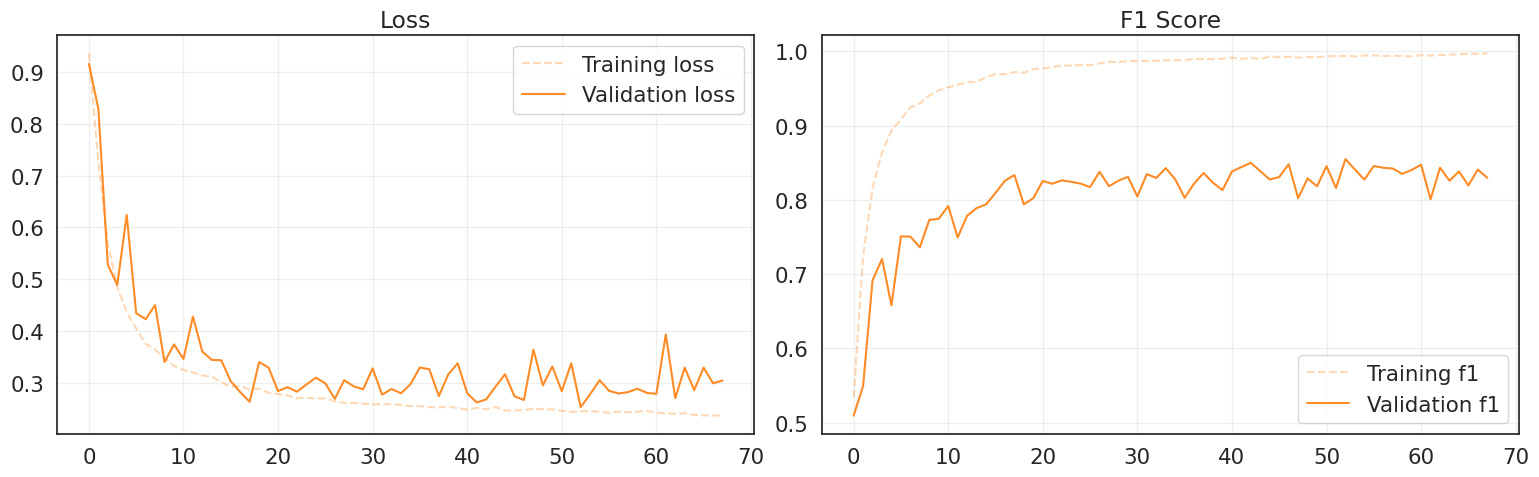

In [47]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9549
Precision over the validation set: 0.9429
Recall over the validation set: 0.8580
F1 score over the validation set: 0.8862


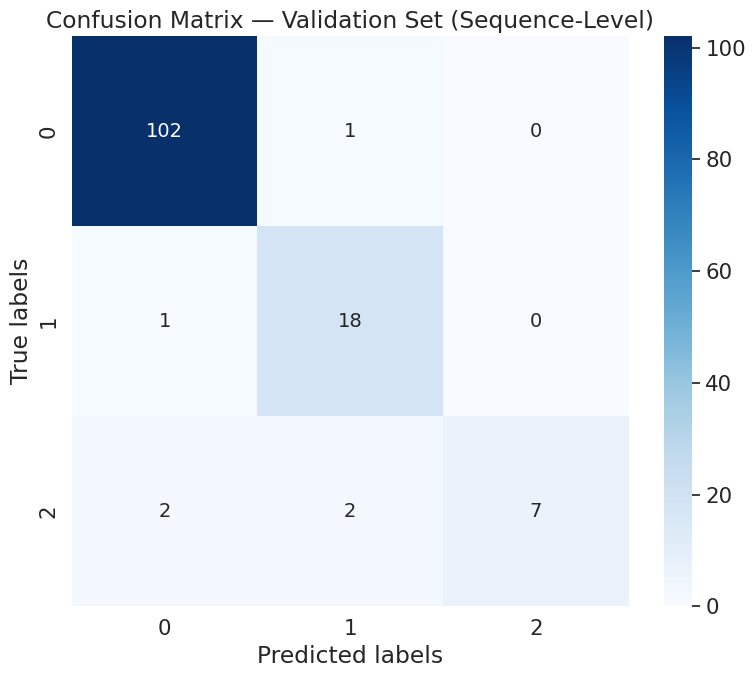

In [48]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
window_to_sample = []  # Track which windows belong to which sample

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)
        
        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        # Store batch results (these are still per-window)
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays (still per-window)
val_preds_windows = np.concatenate(val_preds)
val_targets_windows = np.concatenate(val_targets)

# ============= AGGREGATE WINDOWS TO SEQUENCES =============
# Reconstruct mapping: each sequence produces (160 - W) // S + 1 windows
n_windows_per_seq = (160 - W_SUGG) // S_SUGG + 1

# Map window predictions back to sample_index
unique_samples = X_val["sample_index"].unique()
sequence_preds = {}
sequence_targets = {}

for idx, sid in enumerate(unique_samples):
    # Extract windows for this sequence
    start_idx = idx * n_windows_per_seq
    end_idx = start_idx + n_windows_per_seq
    
    window_preds = val_preds_windows[start_idx:end_idx]
    window_targets = val_targets_windows[start_idx:end_idx]
    
    # Aggregate strategy: MAJORITY VOTE
    from collections import Counter
    vote_counts = Counter(window_preds)
    final_pred = vote_counts.most_common(1)[0][0]
    
    # Target should be same across all windows (sanity check)
    assert len(np.unique(window_targets)) == 1, f"Sample {sid} has inconsistent labels!"
    final_target = window_targets[0]
    
    sequence_preds[sid] = final_pred
    sequence_targets[sid] = final_target

# Convert to arrays for metrics
val_preds = np.array([sequence_preds[sid] for sid in unique_samples])
val_targets = np.array([sequence_targets[sid] for sid in unique_samples])
# ============= END AGGREGATION =============

# Calculate overall validation metrics (now sequence-level)
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='macro')
val_rec = recall_score(val_targets, val_preds, average='macro')
val_f1 = f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Sequence-Level)')
plt.tight_layout()
plt.show()


In [49]:
# choose output directory manually

# --- Kaggle ---
# OUT_DIR = "/kaggle/working"

# --- Cluster (Westworld / Elysium) ---
# OUT_DIR = "/home/cristiano.battistini/storage/an2dl_outputs"

# --- Docker / local environment ---
OUT_DIR = os.path.join(os.getcwd(), "outputs")

# --- Create directory if it doesn't exist ---
os.makedirs(OUT_DIR, exist_ok=True)



In [50]:
def save_experiment_output(
    model_name: str,
    hyperparams: dict,
    X_test_seq: np.ndarray,
    label_mapping: dict,
    sample_indices: list,
    output_dir: str,
    model=None,
    batch_size: int = 256,
    window_size: int = None,
    stride: int = None
):
    """
    Run inference on the test set, save predictions and hyperparameters.

    Args:
        model_name (str): Name of the experiment (e.g. 'lstm', 'bilstm', 'ffn').
        hyperparams (dict): Dict containing all hyperparameters and training config.
        X_test_seq (np.ndarray): Test sequences of shape (N_windows, W, F) — windowed data.
        label_mapping (dict): Mapping from label string to class index.
        sample_indices (list): List of sample_index identifiers (as strings).
        output_dir (str): Folder where submission and metadata are saved.
        model (torch.nn.Module): Trained model for inference.
        batch_size (int): Inference batch size.
        window_size (int): Window size used to create X_test_seq.
        stride (int): Stride used to create X_test_seq.
    """

    os.makedirs(output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Reverse mapping
    idx2label = {v: k for k, v in label_mapping.items()}

    # --- Inference on windows ---
    model.eval().to(device)
    with torch.inference_mode():
        logits = []
        for i in range(0, len(X_test_seq), batch_size):
            xb = torch.from_numpy(X_test_seq[i:i+batch_size]).to(device)
            logits.append(model(xb).cpu().numpy())
        logits = np.concatenate(logits, axis=0)  # (N_windows, num_classes)

    # Get per-window predictions
    pred_idx_windows = logits.argmax(axis=1)  # (N_windows,)

    # --- Aggregate windows to sequences ---
    # Calculate how many windows per sequence (assuming T=160)
    if window_size is None or stride is None:
        # Try to infer from hyperparams if not provided
        window_size = hyperparams.get('window', 12)
        stride = hyperparams.get('stride', 3)
    
    n_windows_per_seq = (160 - window_size) // stride + 1

    # ============= FIX: SORT SAMPLE INDICES =============
    # CRITICAL: X_test_seq windows are created in the order that sample_indices
    # appear in X_test. We must match this order for aggregation.
    # If build_sequences processes sample_indices in sorted order, sort here too.
    sample_indices = sorted(sample_indices)  # Ensure alignment
    # ============= END FIX =============
    
    # Group predictions by sample_index using majority vote
    from collections import Counter
    sequence_predictions = []
    
    for idx in range(len(sample_indices)):
        # Extract windows for this sequence
        start_idx = idx * n_windows_per_seq
        end_idx = start_idx + n_windows_per_seq
        
        window_preds = pred_idx_windows[start_idx:end_idx]
        
        # Majority vote across windows
        vote_counts = Counter(window_preds)
        final_pred_idx = vote_counts.most_common(1)[0][0]
        
        sequence_predictions.append(final_pred_idx)
    
    # Convert indices to labels
    pred_labels = [idx2label[int(i)] for i in sequence_predictions]

    # --- Build submission DataFrame ---
    submission = pd.DataFrame({
        "sample_index": [str(sid).zfill(3) for sid in sample_indices],
        "label": pred_labels
    })

    # --- Build file names ---
    run_name = f"{model_name}_exp"
    csv_path = os.path.join(output_dir, f"{run_name}_submission.csv")
    json_path = os.path.join(output_dir, f"{run_name}_config.json")

    # --- Save submission ---
    submission.to_csv(csv_path, index=False)

    # --- Save hyperparameters as JSON ---
    with open(json_path, "w") as f:
        json.dump(hyperparams, f, indent=4)

    print(f"Saved submission at: {csv_path}")
    print(f"Saved hyperparameters at: {json_path}")
    return submission


In [51]:
# Define your hyperparameters as a dict
hyperparams = {
    "m": MODEL,
    "lr": LEARNING_RATE,
    "epochs": EPOCHS,
    "pat": PATIENCE,
    "hl": HIDDEN_LAYERS,
    "hs": HIDDEN_SIZE,
    "dr": DROPOUT_RATE,
    "l1": L1_LAMBDA,
    "l2": L2_LAMBDA,
    'bi': BIDIRECTIONAL,
    "cnn_channels":CNN_CHANNELS,                  # enables CNN1D preprocessing
    "cnn_kernel_size":CNN_KERNEL_SIZE,                # usually 3, 5, or 7 works well
    "cnn_dropout":CNN_DROPOUT                 # (optional; default uses RNN dropout)
}

model = best_model if "best_model" in globals() else rnn_model
model_name = f"{MODEL.lower()}_bi" if BIDIRECTIONAL else f"{MODEL.lower()}_f"

# Run and save output
submission = save_experiment_output(
    model_name=model_name,
    hyperparams=hyperparams,
    X_test_seq=X_te_win,
    label_mapping={'no_pain': 0, 'low_pain': 1, 'high_pain': 2},
    sample_indices=X_test["sample_index"].unique(),
    output_dir=OUT_DIR,
    model=model,
)


Saved submission at: /kaggle/working/outputs/gru_bi_exp_submission.csv
Saved hyperparameters at: /kaggle/working/outputs/gru_bi_exp_config.json


In [52]:
# ============================================================
# FINAL TRAINING ON THE FULL DATASET + SUBMISSION GENERATION
# ============================================================
RNN_TYPE='GRU'

# 1. Preprocess full training data
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train_full, _ = dataset_conversion_type_embed_ready(DF)
y_full = Y_TRAIN.copy()


labels_full = y_full["label"].map(label_mapping)
y_full_np = labels_full.to_numpy()

num_classes = np.max(y_full_np) + 1  # For 0-indexed labels: [0, 1, 2] → num_classes=3
class_counts = np.bincount(y_full_np, minlength=num_classes)
total = len(y_full_np)

print("\nTraining class distribution:")
for i, name in enumerate(['no_pain', 'low_pain', 'high_pain']):
    print(f"  {name} ({i}): {class_counts[i]} ({class_counts[i]/total*100:.1f}%)")

final_epochs = best_epoch_number
print('final epochs:', final_epochs)


# 3. Merge features and labels
train_merged = X_train_full.merge(y_full, on="sample_index")

# 4. Encode labels numerically BEFORE building sequences
label_mapping = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
train_merged["label"] = train_merged["label"].map(label_mapping)

# 5. Normalise feature values

scale_columns = [col for col in train_merged.columns if col.startswith("joint_")]
# calculate the minimum and maximum values from the training data only
mins = train_merged[scale_columns].min()
maxs = train_merged[scale_columns].max()

# apply normalisation to the specified columns in all datasets (training and validation)
for column in scale_columns:

    # normalise the training set
    train_merged[column] = (train_merged[column] - mins[column]) / (maxs[column] - mins[column])

# 6. Build full sequences
X_train_seq, y_train_seq = build_sequences(train_merged, train_merged[["sample_index", "label"]], window=W_SUGG, stride=S_SUGG)


# 7. DataLoader
train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# 8. Initialize model with tuned hyperparameters
model = RecurrentClassifier(
    input_size=X_train_seq.shape[2],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=len(label_mapping),
    rec_dropout_rate = RECURRENT_DROPOUT,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    cnn_channels=CNN_CHANNELS,                  # enables CNN1D preprocessing
    cnn_kernel_size=CNN_KERNEL_SIZE,                # usually 3, 5, or 7 works well
    cnn_dropout=CNN_DROPOUT,                  # (optional; default uses RNN dropout)
    rnn_type=RNN_TYPE
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

# 9. Train model on the entire dataset
model, history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=None,
    epochs=final_epochs,
    train_criterion=train_criterion,
    val_criterion=None,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=PATIENCE,
    verbose=True,
    evaluation_metric="val_f1",  # ignored since no validation
    mode="max",
    restore_best_weights=False,
    experiment_name="final_full_train"
)

# 10. Prepare test set for inference
X_test = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")
DF_test, _ = preprocess_joints(X_test.copy())
X_test, _ = dataset_conversion_type_embed_ready(DF_test)

for column in scale_columns:
    # normalise the test set
    X_test[column] = (X_test[column] - mins[column]) / (maxs[column] - mins[column])

# Build windowed sequences (this creates N_windows, not N_sequences)
X_test_seq, _ = build_sequences(X_test, None, window=W_SUGG, stride=S_SUGG)

# 11. Save predictions and configuration
OUT_DIR = "results_FULL_model"
os.makedirs(OUT_DIR, exist_ok=True)

hyperparams = {
    "m": MODEL,
    "lr": LEARNING_RATE,
    "epochs": EPOCHS,
    "pat": PATIENCE,
    "hl": HIDDEN_LAYERS,
    "hs": HIDDEN_SIZE,
    "dr": DROPOUT_RATE,
    "l1": L1_LAMBDA,
    "l2": L2_LAMBDA,
    'bi': BIDIRECTIONAL,
    'w': W_SUGG,
    's': S_SUGG
}

# MODIFIED: Pass window_size and stride for aggregation
submission = save_experiment_output(
    model_name=RNN_TYPE.lower(),
    hyperparams=hyperparams,
    X_test_seq=X_test_seq,  # Windowed data (N_windows, W, F)
    label_mapping=label_mapping,
    output_dir=OUT_DIR,
    sample_indices=X_test["sample_index"].unique(),
    model=model,
    window_size=W_SUGG,  # NEW: pass for aggregation
    stride=S_SUGG  # NEW: pass for aggregation
)

print("\n✅ Final model trained and submission saved!")


[preprocess_joints] start=31 | kept=30 | dropped=1
  • dropped: ['joint_30']

Training class distribution:
  no_pain (0): 511 (77.3%)
  low_pain (1): 94 (14.2%)
  high_pain (2): 56 (8.5%)
final epochs: 53
Built 33050 sequences; each shape = (12, 40)
Training 53 epochs...
Epoch   1/53 | Train: Loss=0.7532, F1 Score=0.4652
Epoch   2/53 | Train: Loss=0.6211, F1 Score=0.6733
Epoch   3/53 | Train: Loss=0.5505, F1 Score=0.7526
Epoch   4/53 | Train: Loss=0.5163, F1 Score=0.8028
Epoch   5/53 | Train: Loss=0.4859, F1 Score=0.8464
Epoch   6/53 | Train: Loss=0.4706, F1 Score=0.8662
Epoch   7/53 | Train: Loss=0.4554, F1 Score=0.8865
Epoch   8/53 | Train: Loss=0.4450, F1 Score=0.8995
Epoch   9/53 | Train: Loss=0.4355, F1 Score=0.9111
Epoch  10/53 | Train: Loss=0.4267, F1 Score=0.9195
Epoch  11/53 | Train: Loss=0.4188, F1 Score=0.9276
Epoch  12/53 | Train: Loss=0.4118, F1 Score=0.9352
Epoch  13/53 | Train: Loss=0.4081, F1 Score=0.9380
Epoch  14/53 | Train: Loss=0.4031, F1 Score=0.9442
Epoch  15/53 |

In [53]:
erro.toBreak()

NameError: name 'erro' is not defined

## **K-Shuffle-Split Cross Validation**

In [ ]:
def k_shuffle_split_cross_validation_round_rnn(df, y, epochs, device, k, batch_size, window, stride,
                                               hidden_layers, hidden_size, learning_rate, rec_dropout_rate, 
                                               dropout_rate, rnn_type, bidirectional, cnn_channels, cnn_kernel_size, cnn_dropout,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=SEED, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns
        epochs: Number of training epochs
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_idxs: Number of indexes for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}
    best_epochs_per_fold = {}

    DF, _ = preprocess_joints(X_TRAIN.copy())
    X_train, _  = dataset_conversion_type_embed_ready(DF)
    y = Y_TRAIN.copy()

    # Step 1. temporary merge X_train + y_train to create splits ---
    train_merged = X_train.merge(y, on="sample_index", how="left")

    # Step 2. Retrieve unique indexes ---
    unique_samples = train_merged['sample_index'].unique()

    num_classes = len(train_merged['label'].unique())

    # Prepare stratified K-fold based on label per sample_index
    # ---------------------------------------------------------------
    # Extract one label per sample_index
    label_per_sample = train_merged.groupby("sample_index")["label"].first().map({
        "no_pain": 0, "low_pain": 1, "high_pain": 2
    }).values

    # Create stratified splitter
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    all_splits = list(skf.split(unique_samples, label_per_sample))
    # ---------------------------------------------------------------

    # Store initial weights to reset model for each split
    initial_state = None

    # Iterate through K random splits
    for split_idx, (train_idx, val_idx) in enumerate(all_splits):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # stratified split indices
        train_idxs = unique_samples[train_idx]
        val_idxs   = unique_samples[val_idx]

        # Split the dataset into training, validation, and test sets based on user IDs
        df_train = train_merged[train_merged['sample_index'].isin(train_idxs)].copy()
        df_val = train_merged[train_merged['sample_index'].isin(val_idxs)].copy()

        # X: only features
        X_train = df_train.drop(columns=['label'])
        X_val   = df_val.drop(columns=['label'])

        # y: un'etichetta per ogni sequenza
        y_train = df_train.groupby("sample_index")["label"].first().values
        y_val   = df_val.groupby("sample_index")["label"].first().values

        # Define mapping once
        label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
        inv_label_mapping = {v: k for k, v in label_mapping.items()}

        # Convert y_train/y_val from string → int
        y_train = np.array([label_mapping[l] for l in y_train])
        y_val   = np.array([label_mapping[l] for l in y_val])

        # ============= COMPUTE CLASS WEIGHTS FROM TRAINING FOLD =============
        # Calculate class distribution for this fold's training set
        num_classes_fold = np.max(y_train) + 1
        class_counts_fold = np.bincount(y_train, minlength=num_classes_fold)
        
        if verbose > 0:
            total_train = len(y_train)
            print(f"  Training fold class distribution:")
            for i, name in enumerate(['no_pain', 'low_pain', 'high_pain']):
                print(f"    {name} ({i}): {class_counts_fold[i]} ({class_counts_fold[i]/total_train*100:.1f}%)")
        
        # Compute class weights using the 'maximum count' rule
        max_count_fold = class_counts_fold.max()
        class_weights_fold = max_count_fold / class_counts_fold
        
        # Use SQRT dampening for weights (more balanced)
        class_weights_fold_dampened = np.sqrt(class_weights_fold)
        class_weights = torch.tensor(class_weights_fold_dampened, dtype=torch.float32)

        if verbose > 0:
            print(f"  Class weights (raw): {class_weights_fold}")
            print(f"  Class weights (sqrt dampened): {class_weights_fold_dampened}")
        
        # Define training criterion with FocalLabelSmoothing (NEW)
        train_criterion = WeightLabelLoss(
            num_classes=num_classes_fold,
            class_weights=class_weights_fold_dampened,  # Use sqrt dampened weights
        ).to(device)
        

        # ============= END CLASS WEIGHTS COMPUTATION =============

        # Normalise features using training set statistics
        scale_columns = [col for col in X_train.columns if col.startswith("joint_")]

        train_max = X_train[scale_columns].max()
        train_min = X_train[scale_columns].min()

        X_train[scale_columns] = (X_train[scale_columns] - train_min) / (train_max - train_min + 1e-8)
        X_val[scale_columns] = (X_val[scale_columns] - train_min) / (train_max - train_min + 1e-8)

        if verbose > 0:
            print(f"  Training set shape: {X_train.shape}")
            print(f"  Validation set shape: {X_val.shape}")

        y_train_df = pd.DataFrame({
            "sample_index": X_train["sample_index"].unique(),
            "label": y_train
        })

        X_train_seq, y_train_seq = build_sequences(X_train, y_train_df, window, stride)

        y_val_df = pd.DataFrame({
            "sample_index": X_val["sample_index"].unique(),
            "label": y_val
        })

        X_val_seq, y_val_seq = build_sequences(X_val, y_val_df, window, stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train_seq.shape}")
            print(f"  Validation sequences shape: {X_val_seq.shape}")

        input_shape = X_train_seq.shape[1:] # extract the shape of a single sequence
        num_classes = len(np.unique(y_train)) # how many unique pain level exists

        if verbose > 0:
            print(f"  Input shape: {input_shape}")
            print(f"  Num classes: {num_classes}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
        val_ds   = TensorDataset(torch.from_numpy(X_val_seq), torch.from_numpy(y_val_seq))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Initialise model architecture
        model = RecurrentClassifier(
            input_size=input_shape[-1],
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            rec_dropout_rate=rec_dropout_rate,
            bidirectional=bidirectional,
            cnn_channels=cnn_channels,                  # enables CNN1D preprocessing
            cnn_kernel_size=cnn_kernel_size,                # usually 3, 5, or 7 works well
            cnn_dropout=cnn_dropout,                  # (optional; default uses RNN dropout)
            rnn_type=rnn_type
        ).to(device)

        # 3. save initial state at 1st split, reset in the following splits
        if initial_state is None:
            # the first split (split_idx == 0)
            # save initial random weights
            initial_state = copy.deepcopy(model.state_dict())
        else:
            # Questo è uno split successivo (1, 2, ...)
            # Resetta il modello ai pesi iniziali salvati
            model.load_state_dict(initial_state)
        
        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=7, verbose=True, min_lr=1e-6)
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=15,        # Restart every 15 epochs
            T_mult=2,      # Double restart period each time
            eta_min=1e-6   # Minimum LR
        )
        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Validation criterion (standard CrossEntropy without smoothing)
        val_criterion = nn.CrossEntropyLoss()to(device)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            train_criterion=train_criterion,  # Use fold-specific FocalLabelSmoothing
            val_criterion=val_criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            scheduler=scheduler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

        best_epoch_idx = training_history['val_f1'].index(max(training_history['val_f1']))
        best_epochs_per_fold[f"split_{split_idx}"] = best_epoch_idx


    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["mean_best_epoch"] = np.mean([
        best_epochs_per_fold[k] for k in best_epochs_per_fold.keys() if k.startswith("split_")
    ])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores


## **Hyperparameters Tuning**

In [ ]:
import pickle

def grid_search_cv_rnn(df, y, param_grid, fixed_params, cv_params, verbose=True, n_iter=60, 
                       checkpoint_every=10, early_prune_threshold=0.8):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns 
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration
        checkpoint_every: Save results every N iterations (default 10)
        early_prune_threshold: Stop config if score < best_score * threshold after 2 folds (default 0.7)

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
        best_config_epochs: Mean best epoch from best configuration
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))

    total_possible = len(all_combinations)

    
    results = {}
    best_score = -np.inf
    best_config = None
    best_config_epochs = None

    # If n_iter is None, set it to total_possible to run a full grid search
    if n_iter is None:
        n_iter = total_possible

    # Se n_iter è minore del totale, scegli N combinazioni a caso
    if n_iter < total_possible:
        print(f"--- Eseguendo RANDOM SEARCH ---")
        print(f"Selezionate {n_iter} combinazioni casuali su {total_possible} possibili.")
        # Use seed for reproducibility
        random.seed(cv_params.get('seed', 42))
        combinations = random.sample(all_combinations, n_iter)
    else:
        print(f"--- Eseguendo GRID SEARCH ---")
        print(f"Testando tutte le {total_possible} combinazioni.")
        combinations = all_combinations

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            if n_iter < total_possible:
                print(f"\nConfiguration {idx}/{n_iter}:")
            else:
                 print(f"\nConfiguration {idx}/{total_possible}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation 
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            y=y,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Early pruning: skip config if performance is too poor after initial folds
        if best_score > -np.inf:  # Only prune after we have a baseline
            partial_scores = fold_scores.get('scores', [])
            if len(partial_scores) >= 2:
                partial_mean = np.mean(partial_scores[:2])
                if partial_mean < best_score * early_prune_threshold:
                    if verbose:
                        print(f"  [PRUNED] Score {partial_mean:.4f} < {best_score * early_prune_threshold:.4f} (threshold), skipping.")
                    results[config_str] = fold_scores  # Still save for analysis
                    continue

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            best_config_epochs = fold_scores["mean_best_epoch"]
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

        # Save checkpoint periodically
        if idx % checkpoint_every == 0:
            checkpoint_path = f'grid_search_checkpoint_{idx}.pkl'
            with open(checkpoint_path, 'wb') as f:
                pickle.dump({
                    'results': results,
                    'best_config': best_config,
                    'best_score': best_score,
                    'best_config_epochs': best_config_epochs,
                    'completed_idx': idx,
                    'total': n_iter if n_iter < total_possible else total_possible
                }, f)
            if verbose:
                print(f"  [CHECKPOINT] Salvato in {checkpoint_path}")

    # Final save
    final_path = 'grid_search_final.pkl'
    with open(final_path, 'wb') as f:
        pickle.dump({
            'results': results,
            'best_config': best_config,
            'best_score': best_score,
            'best_config_epochs': best_config_epochs
        }, f)
    print(f"\n[COMPLETATO] Risultati salvati in {final_path}")

    return results, best_config, best_score, best_config_epochs


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'window_':'W=',
        'stride_':'S=',
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_window_':'\nW=',
        '_stride_':'\nS=',
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train, _ = dataset_conversion_type_embed_ready(DF)
y = Y_TRAIN.copy()

In [ ]:
K = 5
VAL_FRAC = 0.20  # 20% sequences for validation in each split
N = X_train['sample_index'].nunique()  # Returns integer


In [ ]:
%%time

# Define parameters to search
param_grid_phase1 = {
    'batch_size': [64, 128, 256],
    'learning_rate': [3e-4, 5e-4, 7e-4],
    
    # Fixed to your proven baseline
    'hidden_size': [192],
    'hidden_layers': [2],
    'dropout_rate': [0.5],
    'l2_lambda': [1e-4],
    'window': [12],
    'stride': [3],
    'rnn_type': ['GRU'],
    'bidirectional': [True],
    'epochs': [150],
    'patience': [10],
}


# Fixed hyperparameters (not being tuned)
fixed_params = {
    'l1_lambda': L1_LAMBDA,
    'cnn_channels':CNN_CHANNELS,                  # enables CNN1D preprocessing
    'cnn_kernel_size':CNN_KERNEL_SIZE,                # usually 3, 5, or 7 works well
    'cnn_dropout': CNN_DROPOUT,                  # (optional; default uses RNN dropout)
}


# Cross-validation settings
cv_params = {
    'device': device,
    'k': K,
    'verbose': 0,
    'seed': SEED
}

# Run aggressive random search
# Total possible: 3×3×3×3×3×4×2×2 = 3,888 combinations
# Testing: 60 random samples (~1.5% of total)
results, best_config, best_score, best_epochs = grid_search_cv_rnn(
    df=df_train,
    y=y_train,
    param_grid=param_grid_phase1,
    fixed_params=fixed_params,
    cv_params=cv_params,
    verbose=True,
    n_iter=None,  # Sample 60 random configurations
    checkpoint_every=10,  # Save every 10 iterations
    early_prune_threshold=0.70  # Skip if score < 70% of best
)

print(f"\n{'='*60}")
print(f"BEST CONFIGURATION:")
for k, v in best_config.items():
    print(f"  {k}: {v}")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Epochs: {best_epochs:.1f}")
print(f"{'='*60}")


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
%%time

param_grid_phase2 = {
    'batch_size': [best_config['batch_size']],
    'learning_rate': [best_config['learning_rate']],
    
    # Now explore architecture
    'hidden_size': [128, 192, 256],
    'hidden_layers': [2, 3],
    'dropout_rate': [0.4, 0.5],
    
    # Fixed
    'l2_lambda': [1e-4],
    'window': [12],
    'stride': [3],
    'rnn_type': ['GRU'],
    'bidirectional': [True],
    'epochs': [150],
    'patience': [10],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'l1_lambda': L1_LAMBDA,
    'dropout_rate': RECURRENT_DROPOUT
}

# Cross-validation settings
cv_params = {
    'device': device,
    'k': K,
    'verbose': 0,
    'seed': SEED
}

# Run aggressive random search
# Total possible: 3×3×3×3×3×4×2×2 = 3,888 combinations
# Testing: 60 random samples (~1.5% of total)
results, best_config, best_score, best_epochs = grid_search_cv_rnn(
    df=df_train,
    y=y_train,
    param_grid=param_grid_phase2,
    fixed_params=fixed_params,
    cv_params=cv_params,
    verbose=True,
    n_iter=None,  # Sample 60 random configurations
    checkpoint_every=10,  # Save every 10 iterations
    early_prune_threshold=0.70  # Skip if score < 70% of best
)

print(f"\n{'='*60}")
print(f"BEST CONFIGURATION:")
for k, v in best_config.items():
    print(f"  {k}: {v}")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Epochs: {best_epochs:.1f}")
print(f"{'='*60}")


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
%%time

param_grid_phase3 = {
    'batch_size': [best_config['batch_size']],
    'learning_rate': [best_config['learning_rate']],
    'hidden_size': [best_config['hidden_size']],
    'hidden_layers': [best_config['hidden_layers']],
    'dropout_rate': [best_config['dropout_rate']],
    
    # Now explore window/stride/L2
    'window': [12, 16, 20],
    'stride': [2, 3, 4],
    'l2_lambda': [3e-5, 1e-4, 3e-4],
    
    'rnn_type': ['GRU'],
    'bidirectional': [True],
    'epochs': [150],
    'patience': [10],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'l1_lambda': L1_LAMBDA,
}

# Cross-validation settings
cv_params = {
    'device': device,
    'k': K,
    'verbose': 0,
    'seed': SEED
}

# Run aggressive random search
# Total possible: 3×3×3×3×3×4×2×2 = 3,888 combinations
# Testing: 60 random samples (~1.5% of total)
results, best_config, best_score, best_epochs = grid_search_cv_rnn(
    df=df_train,
    y=y_train,
    param_grid=param_grid_phase3,
    fixed_params=fixed_params,
    cv_params=cv_params,
    verbose=True,
    n_iter=13,  # Sample 60 random configurations
    checkpoint_every=10,  # Save every 10 iterations
    early_prune_threshold=0.70  # Skip if score < 70% of best
)

print(f"\n{'='*60}")
print(f"BEST CONFIGURATION:")
for k, v in best_config.items():
    print(f"  {k}: {v}")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Epochs: {best_epochs:.1f}")
print(f"{'='*60}")


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# ============================================================
# FINAL TRAINING ON THE FULL DATASET + SUBMISSION GENERATION
# ============================================================

# 1. Preprocess full training data
DF, _ = preprocess_joints(X_TRAIN.copy())
X_train_full, _ = dataset_conversion_type_embed_ready(DF)
y_full = Y_TRAIN.copy()


labels_full = y_full["label"].map(label_mapping)
y_full_np = labels_full.to_numpy()

num_classes = np.max(y_full_np) + 1  # For 0-indexed labels: [0, 1, 2] → num_classes=3
class_counts = np.bincount(y_full_np, minlength=num_classes)
total = len(y_full_np)

print("\nTraining class distribution:")
for i, name in enumerate(['no_pain', 'low_pain', 'high_pain']):
    print(f"  {name} ({i}): {class_counts[i]} ({class_counts[i]/total*100:.1f}%)")

# Compute class weights using the 'maximum count' rule (makes the most common class weight=1.0)
max_count = class_counts.max()
class_weights = max_count / class_counts
print(f"Class weights: {class_weights}")

# For use in PyTorch or your label smoothing class:
class_weights_dampened = np.sqrt(class_weights)
class_weights = torch.tensor(class_weights_dampened, dtype=torch.float32)

# Define training criterion with class-aware label smoothing
train_criterion = WeightLabelLoss(
    num_classes=3,
    class_weights=class_weights              # Use automatic weights
).to(device)


# 2. Combine the best hyperparameters (found in grid search)
final_best_params = {**fixed_params, **best_config}

# Use mean best epoch from CV + 20% buffer (more data → slightly more epochs)
final_epochs = int(best_epochs * 1)
print(f"\n📊 CV found best performance at epoch {best_epochs:.1f} (average)")
print(f"   Final training will use {final_epochs} epochs (20% buffer for full dataset)")

final_best_params['epochs'] = final_epochs


print("Training final model with best configuration:")
for k, v in final_best_params.items():
    print(f"  {k}: {v}")

# 3. Merge features and labels
train_merged = X_train_full.merge(y_full, on="sample_index")

# 4. Encode labels numerically BEFORE building sequences
label_mapping = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
train_merged["label"] = train_merged["label"].map(label_mapping)



# 5. Normalise feature values

scale_columns = [col for col in train_merged.columns if col.startswith("joint_")]
# calculate the minimum and maximum values from the training data only
mins = X_train[scale_columns].min()
maxs = X_train[scale_columns].max()

# apply normalisation to the specified columns in all datasets (training and validation)
for column in scale_columns:

    # normalise the training set
    train_merged[column] = (train_merged[column] - mins[column]) / (maxs[column] - mins[column])

# 6. Build full sequences
X_train_seq, y_train_seq = build_sequences(train_merged, train_merged[["sample_index", "label"]], window=final_best_params["window"], stride=final_best_params["stride"])


# 7. DataLoader
train_ds = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq))
train_loader = make_loader(train_ds, batch_size=final_best_params["batch_size"], shuffle=True, drop_last=False)

# 8. Initialize model with tuned hyperparameters
model = RecurrentClassifier(
    input_size=X_train_seq.shape[2],
    hidden_size=final_best_params["hidden_size"],
    num_layers=final_best_params["hidden_layers"],
    num_classes=len(label_mapping),
    rec_dropout_rate = RECURRENT_DROPOUT,
    dropout_rate=final_best_params["dropout_rate"],
    bidirectional=final_best_params["bidirectional"],
    rnn_type=final_best_params["rnn_type"],
    cnn_channels=final_best_params["cnn_channels"],                  # enables CNN1D preprocessing
    cnn_kernel_size=final_best_params["cnn_kernel_size"],                # usually 3, 5, or 7 works well
    cnn_dropout=final_best_params["cnn_dropout"],                  # (optional; default uses RNN dropout)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=final_best_params["learning_rate"], weight_decay=final_best_params['l2_lambda'])
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

# 9. Train model on the entire dataset
model, history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=None,
    epochs=final_epochs,
    train_criterion=train_criterion,
    val_criterion=None,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    patience=final_best_params["patience"],
    verbose=True,
    evaluation_metric="val_f1",  # ignored since no validation
    mode="max",
    restore_best_weights=False,
    experiment_name="final_full_train"
)

# 10. Prepare test set for inference
X_test = pd.read_csv(DATASET_ROOT / "pirate_pain_test.csv")
DF_test, _ = preprocess_joints(X_test.copy())
X_test, _ = dataset_conversion_type_embed_ready(DF_test)

for column in scale_columns:
    # normalise the test set
    X_test[column] = (X_test[column] - mins[column]) / (maxs[column] - mins[column])

# Build windowed sequences (this creates N_windows, not N_sequences)
X_test_seq, _ = build_sequences(X_test, None, window=final_best_params["window"], stride=final_best_params["stride"])

# 11. Save predictions and configuration
OUT_DIR = "results_best_model"
os.makedirs(OUT_DIR, exist_ok=True)

hyperparams = final_best_params.copy()
hyperparams.update({
    "best_cv_f1": best_score
})

# MODIFIED: Pass window_size and stride for aggregation
submission = save_experiment_output(
    model_name=final_best_params["rnn_type"].lower(),
    hyperparams=hyperparams,
    X_test_seq=X_test_seq,  # Windowed data (N_windows, W, F)
    label_mapping=label_mapping,
    output_dir=OUT_DIR,
    sample_indices=X_test["sample_index"].unique(),
    model=model,
    window_size=final_best_params["window"],  # NEW: pass for aggregation
    stride=final_best_params["stride"]  # NEW: pass for aggregation
)

print("\n✅ Final model trained and submission saved!")
